In [41]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [42]:
# Set plot style for better visuals
sns.set_style("whitegrid")

# Load dataset
df = pd.read_csv('crop_yield.csv')

# Display basic information
print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Region                  5000 non-null   object 
 1   Soil_Type               5000 non-null   object 
 2   Crop                    5000 non-null   object 
 3   Rainfall_mm             5000 non-null   object 
 4   Temperature_Celsius     5000 non-null   float64
 5   Fertilizer_Used         5000 non-null   bool   
 6   Irrigation_Used         5000 non-null   bool   
 7   Weather_Condition       5000 non-null   object 
 8   Days_to_Harvest         5000 non-null   int64  
 9   Yield_tons_per_hectare  5000 non-null   float64
dtypes: bool(2), float64(2), int64(1), object(5)
memory usage: 322.4+ KB
None

First 5 Rows:
  Region Soil_Type     Crop  Rainfall_mm  Temperature_Celsius  \
0   West     Sandy   Cotton  897.0772391            27.676966   
1  South      Clay  

In [43]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Region                    0
Soil_Type                 0
Crop                      0
Rainfall_mm               0
Temperature_Celsius       0
Fertilizer_Used           0
Irrigation_Used           0
Weather_Condition         0
Days_to_Harvest           0
Yield_tons_per_hectare    0
dtype: int64


In [ ]:
# Define numerical and categorical columns
numerical_cols = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']
categorical_cols = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']
boolean_cols = ['Fertilizer_Used', 'Irrigation_Used']

# Check for non-numeric values in numerical columns
for col in numerical_cols:

    df[col] = pd.to_numeric(df[col], errors='coerce')
    non_numeric_count = df[col].isna().sum()
    if non_numeric_count > 0:
        print(f"Found {non_numeric_count} non-numeric values in {col}. Converted to NaN.")

for col in numerical_cols:
    if df[col].isna().any():
        df[col].fillna(df[col].mean(), inplace=True)
        print(f"Imputed missing values in {col} with mean: {df[col].mean():.2f}")



In [47]:
# Handle missing values in categorical columns
for col in categorical_cols:
    if df[col].isna().any():
        df[col].fillna(df[col].mode()[0], inplace=True)
        print(f"Imputed missing values in {col} with mode: {df[col].mode()[0]}")

# Verify data types after cleaning
print("\nData Types After Cleaning:")
print(df.dtypes)


Data Types After Cleaning:
Region                     object
Soil_Type                  object
Crop                       object
Rainfall_mm               float64
Temperature_Celsius       float64
Fertilizer_Used              bool
Irrigation_Used              bool
Weather_Condition          object
Days_to_Harvest             int64
Yield_tons_per_hectare    float64
dtype: object


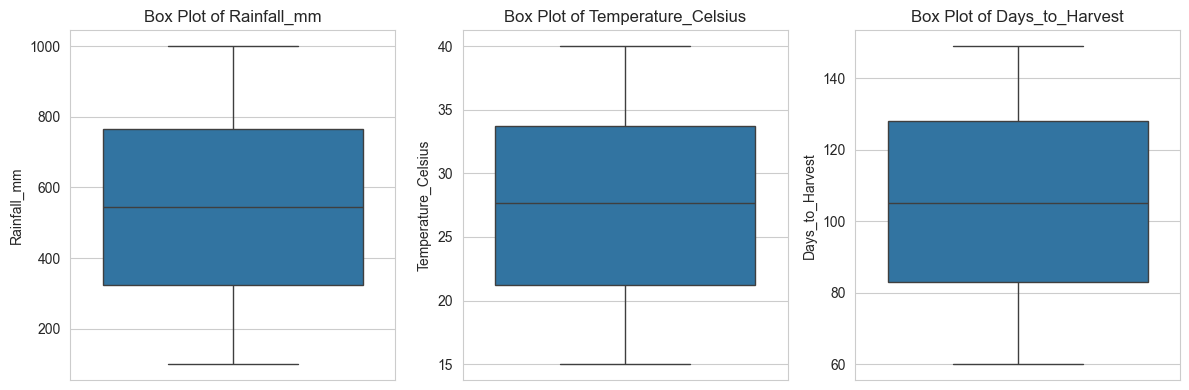

Removed 0 outliers in Rainfall_mm beyond 3 std deviations
Removed 0 outliers in Temperature_Celsius beyond 3 std deviations
Removed 0 outliers in Days_to_Harvest beyond 3 std deviations


In [48]:
# Visualize outliers with box plots
plt.figure(figsize=(12, 4))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

# Remove extreme outliers (beyond 3 standard deviations)
for col in numerical_cols:
    mean, std = df[col].mean(), df[col].std()
    outliers = (df[col] < mean - 3 * std) | (df[col] > mean + 3 * std)
    print(f"Removed {outliers.sum()} outliers in {col} beyond 3 std deviations")
    df = df[~outliers]

In [49]:
# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
        ('bool', 'passthrough', boolean_cols)
    ])




In [50]:
# Split features and target
X = df.drop(columns=['Yield_tons_per_hectare'])
y = df['Yield_tons_per_hectare']

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

In [51]:

# Train/validation/test split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (3500, 22)
Validation set shape: (750, 22)
Test set shape: (750, 22)


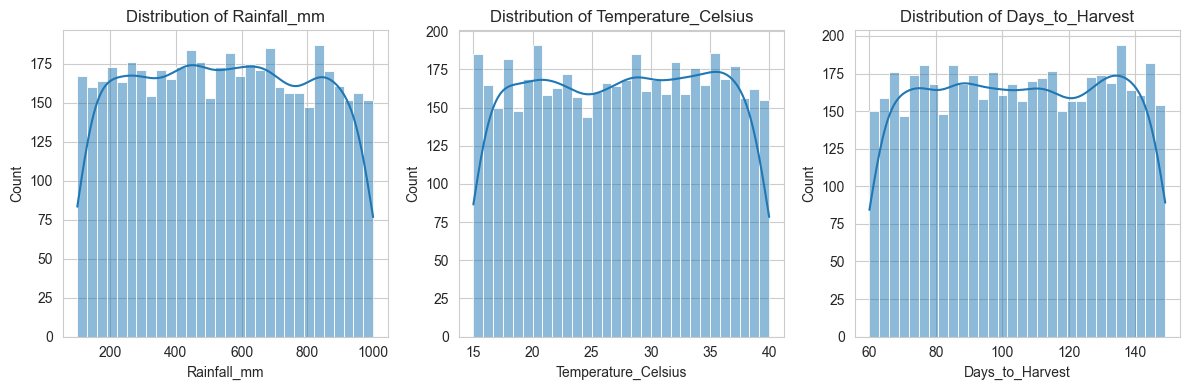

In [52]:
# Histograms for numerical features
plt.figure(figsize=(12, 4))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()






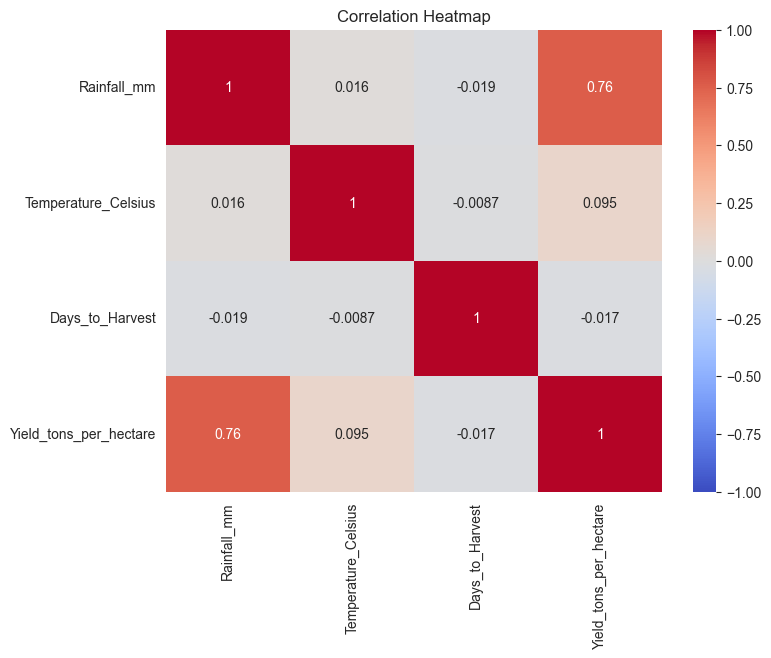

In [53]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
corr_matrix = df[numerical_cols + ['Yield_tons_per_hectare']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

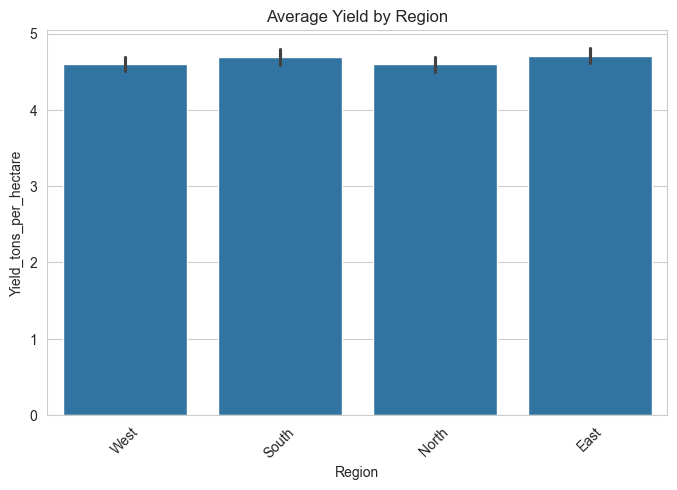

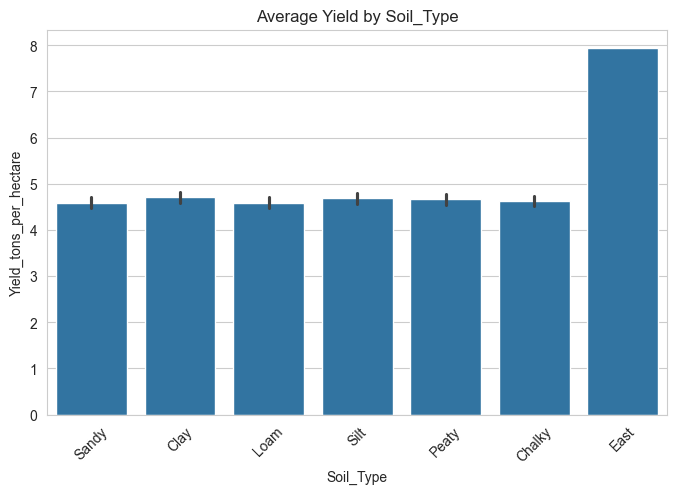

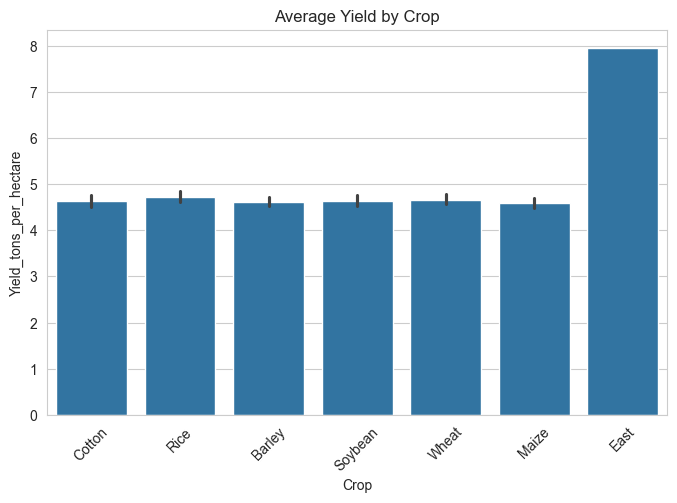

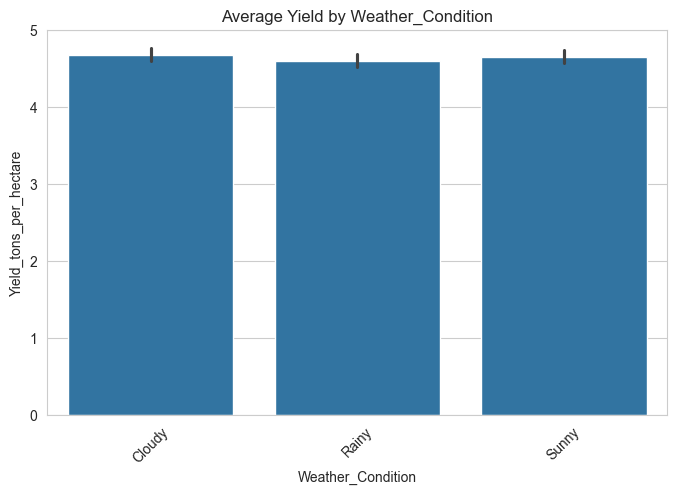

In [54]:
# Bar plots for average yield by categorical features
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=col, y='Yield_tons_per_hectare', data=df)
    plt.title(f'Average Yield by {col}')
    plt.xticks(rotation=45)
    plt.show()

In [56]:
# Import libraries for feature engineering
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

# Create new features in the original dataframe
df['Rainfall_Temperature_Interaction'] = df['Rainfall_mm'] * df['Temperature_Celsius']




In [ ]:
# Polynomial features: Square of Rainfall and Temperature
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['Rainfall_mm', 'Temperature_Celsius']])
poly_cols = ['Rainfall_mm_squared', 'Temperature_Celsius_squared']
df_poly = pd.DataFrame(poly_features[:, [2, 3]], columns=poly_cols)  # Select squared terms only
df = pd.concat([df, df_poly], axis=1)

median_rainfall = df['Rainfall_mm'].median()
df['High_Rainfall'] = (df['Rainfall_mm'] > median_rainfall).astype(int)


In [58]:
# Display new features
print("\nNew Features Added:")
print(df[['Rainfall_Temperature_Interaction', 'Rainfall_mm_squared', 'Temperature_Celsius_squared', 'High_Rainfall']].head())


New Features Added:
   Rainfall_Temperature_Interaction  Rainfall_mm_squared  \
0                      24828.376578        804747.572911   
1                      17894.069782        985400.244003   
2                       4409.459444         21903.415493   
3                      16425.590910        973905.155854   
4                      23095.091535        533453.738397   

   Temperature_Celsius_squared  High_Rainfall  
0                 24828.376578              1  
1                 17894.069782              1  
2                  4409.459444              0  
3                 16425.590910              1  
4                 23095.091535              1  


In [59]:
# Update numerical columns for preprocessing
numerical_cols_updated = numerical_cols + ['Rainfall_Temperature_Interaction', 'Rainfall_mm_squared', 'Temperature_Celsius_squared']
boolean_cols_updated = boolean_cols + ['High_Rainfall']


In [60]:
# Update preprocessing pipeline
preprocessor_updated = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_updated),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
        ('bool', 'passthrough', boolean_cols_updated)
    ])

# Split features and target
X = df.drop(columns=['Yield_tons_per_hectare'])
y = df['Yield_tons_per_hectare']

In [61]:

# Apply preprocessing
X_preprocessed = preprocessor_updated.fit_transform(X)

# Get feature names after preprocessing
cat_feature_names = preprocessor_updated.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols_updated + list(cat_feature_names) + boolean_cols_updated

In [62]:
# Train/validation/test split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nUpdated Training set shape: {X_train.shape}")
print(f"Updated Validation set shape: {X_val.shape}")
print(f"Updated Test set shape: {X_test.shape}")


Updated Training set shape: (3500, 26)
Updated Validation set shape: (750, 26)
Updated Test set shape: (750, 26)


In [63]:
# Train Random Forest to get feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [64]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("\nTop 10 Feature Importance:")
print(feature_importance.head(10))


Top 10 Feature Importance:
                             Feature  Importance
4                Rainfall_mm_squared    0.306571
0                        Rainfall_mm    0.285951
23                   Fertilizer_Used    0.199570
24                   Irrigation_Used    0.120517
5        Temperature_Celsius_squared    0.019277
3   Rainfall_Temperature_Interaction    0.016989
2                    Days_to_Harvest    0.015046
1                Temperature_Celsius    0.011917
21           Weather_Condition_Rainy    0.001979
8                        Region_West    0.001928


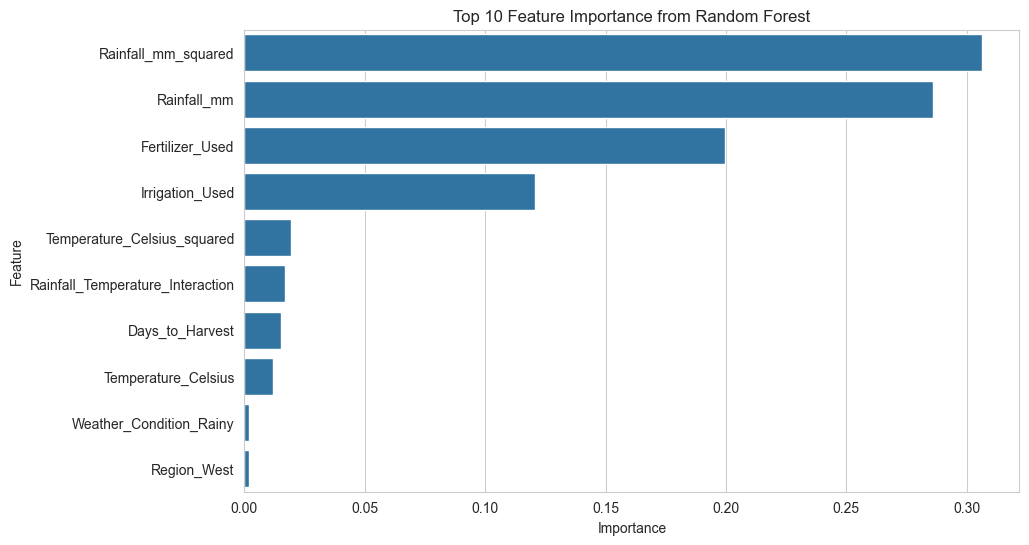

In [65]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance from Random Forest')
plt.show()

In [66]:
# Select top features (e.g., importance > 0.01)
selected_features = feature_importance[feature_importance['Importance'] > 0.01]['Feature'].tolist()
print(f"\nSelected Features (Importance > 0.01): {selected_features}")


Selected Features (Importance > 0.01): ['Rainfall_mm_squared', 'Rainfall_mm', 'Fertilizer_Used', 'Irrigation_Used', 'Temperature_Celsius_squared', 'Rainfall_Temperature_Interaction', 'Days_to_Harvest', 'Temperature_Celsius']


In [67]:
# Filter preprocessed data to include only selected features
selected_indices = [i for i, name in enumerate(feature_names) if name in selected_features]
X_train_selected = X_train[:, selected_indices]
X_val_selected = X_val[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

print(f"\nSelected Training set shape: {X_train_selected.shape}")
print(f"Selected Validation set shape: {X_val_selected.shape}")
print(f"Selected Test set shape: {X_test_selected.shape}")


Selected Training set shape: (3500, 8)
Selected Validation set shape: (750, 8)
Selected Test set shape: (750, 8)


In [68]:
# Import libraries for model building
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Dictionary to store performance metrics
results = {'Model': [], 'Validation RMSE': [], 'Validation R²': []}



In [69]:
# Train and evaluate each model
for name, model in models.items():
    # Train model
    model.fit(X_train_selected, y_train)
    
    # Predict on validation set
    y_val_pred = model.predict(X_val_selected)
    
    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)
    
    # Store results
    results['Model'].append(name)
    results['Validation RMSE'].append(rmse)
    results['Validation R²'].append(r2)
    
    print(f"\n{name}:")
    print(f"Validation RMSE: {rmse:.4f}")
    print(f"Validation R²: {r2:.4f}")




Linear Regression:
Validation RMSE: 0.4998
Validation R²: 0.9111

Random Forest:
Validation RMSE: 0.5339
Validation R²: 0.8986

XGBoost:
Validation RMSE: 0.5747
Validation R²: 0.8825


In [70]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)



In [71]:
grid_search.fit(X_train_selected, y_train)

# Get best Random Forest model
best_rf = grid_search.best_estimator_
print(f"\nBest Random Forest Parameters: {grid_search.best_params_}")

# Evaluate tuned Random Forest
y_val_pred_rf = best_rf.predict(X_val_selected)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
r2_rf = r2_score(y_val, y_val_pred_rf)

# Update results with tuned Random Forest
results['Model'].append('Tuned Random Forest')
results['Validation RMSE'].append(rmse_rf)
results['Validation R²'].append(r2_rf)

print(f"\nTuned Random Forest:")
print(f"Validation RMSE: {rmse_rf:.4f}")
print(f"Validation R²: {r2_rf:.4f}")




Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Tuned Random Forest:
Validation RMSE: 0.5237
Validation R²: 0.9024


In [72]:
# Display results
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df)

# Select best model based on lowest RMSE
best_model_name = results_df.loc[results_df['Validation RMSE'].idxmin(), 'Model']
print(f"\nBest Model: {best_model_name}")




Model Performance Summary:
                 Model  Validation RMSE  Validation R²
0    Linear Regression         0.499789       0.911104
1        Random Forest         0.533901       0.898555
2              XGBoost         0.574704       0.882457
3  Tuned Random Forest         0.523680       0.902402

Best Model: Linear Regression


In [73]:
# Train best model on combined train+validation set for final evaluation
best_model = best_rf if best_model_name == 'Tuned Random Forest' else models[best_model_name]
X_train_val = np.vstack((X_train_selected, X_val_selected))
y_train_val = np.concatenate((y_train, y_val))
best_model.fit(X_train_val, y_train_val)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


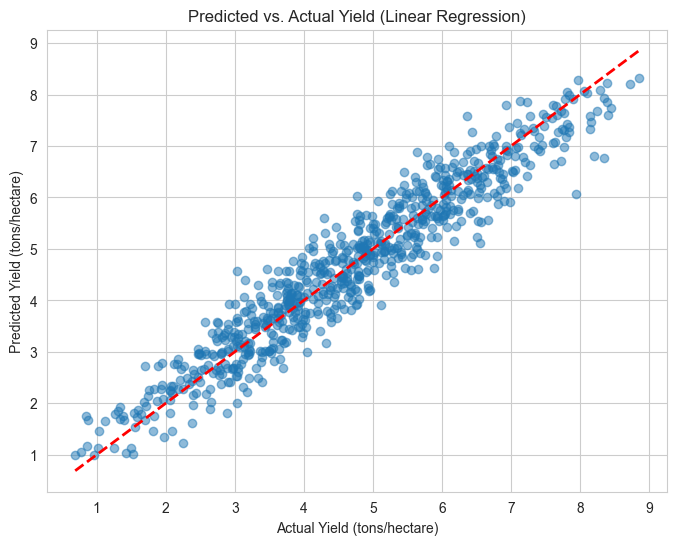

In [74]:
# Predict with best model on validation set
y_val_pred_best = best_model.predict(X_val_selected)

# Scatter plot of predicted vs. actual yields
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred_best, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Yield (tons/hectare)')
plt.ylabel('Predicted Yield (tons/hectare)')
plt.title(f'Predicted vs. Actual Yield ({best_model_name})')
plt.show()

In [75]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate best model on test set
y_test_pred = best_model.predict(X_test_selected)
# Compute metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nBest Model ({best_model_name}) Test Set Performance:")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")



Best Model (Linear Regression) Test Set Performance:
Test RMSE: 0.4968
Test R²: 0.9146


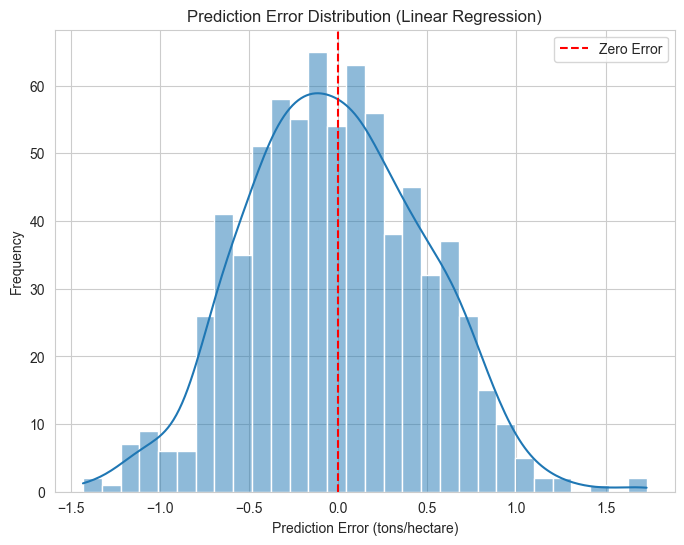

In [76]:

# Analyze prediction errors
errors = y_test - y_test_pred

# Plot histogram of prediction errors
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel('Prediction Error (tons/hectare)')
plt.ylabel('Frequency')
plt.title(f'Prediction Error Distribution ({best_model_name})')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
plt.legend()
plt.show()


In [78]:

# Check for systematic bias
mean_error = errors.mean()
print(f"Mean Prediction Error: {mean_error:.4f} ")

Mean Prediction Error: -0.0181 


In [79]:
# Get feature importance or coefficients
if best_model_name in ['Random Forest', 'Tuned Random Forest', 'XGBoost']:
    importance = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in selected_indices],
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)
else:  # Linear Regression
    coefficients = best_model.coef_
    feature_importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in selected_indices],
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False, key=abs)


In [80]:

# Display top 5 features
print("\nTop 5 Features Influencing Yield:")
print(feature_importance_df.head())



Top 5 Features Influencing Yield:
               Feature  Coefficient
6      Fertilizer_Used     1.524833
0          Rainfall_mm     1.293347
7      Irrigation_Used     1.197703
1  Temperature_Celsius     0.147323
4  Rainfall_mm_squared    -0.030691


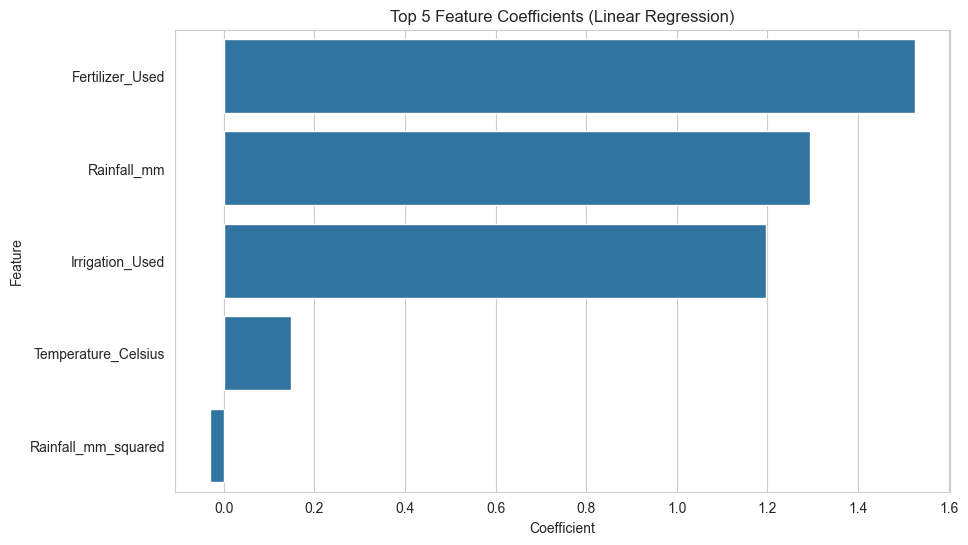

In [81]:

# Visualize feature importance
plt.figure(figsize=(10, 6))
if best_model_name in ['Random Forest', 'Tuned Random Forest', 'XGBoost']:
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head())
    plt.title(f'Top 5 Feature Importance ({best_model_name})')
else:
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df.head())
    plt.title(f'Top 5 Feature Coefficients ({best_model_name})')
plt.show()

In [83]:


# Save test set predictions to CSV
predictions_df = pd.DataFrame({
    'Actual_Yield': y_test,
    'Predicted_Yield': y_test_pred
})
predictions_df.to_csv('test_predictions.csv', index=False)
print("\nTest predictions saved to 'test_predictions.csv'.")


Test predictions saved to 'test_predictions.csv'.
